# Basics of BOSSA 2: the orbital parameters

## Introduction

The `zams` module implements the correlated initial orbital parameter distributions from Moe & Di Stefano (2017) (MD17), the uncorrelated distributions, and draws orbital parameters for a list of masses. `ZAMSSystemGenerator` class is a **sampling** class, all others are **distribution** classes.

* `EccentricityDistribution`: either always draws e=0 (`canonical=True`) or samples from the MD17 distribution (`canonical=False`) (sec 2.2.2),
* `MassRatioDistribution`:  either uniform (`canonical=True`) or the correlated distribution from MD17 (`canonical=False`) (sec 2.2.1),
* `CompanionFrequencyDistributionHighQ`: this only implements the original fit from MD17 for the companion frequency as a function of primary mass and period in pairs of stars with q>0.3; this is not supposed to be accessed directly, but is instead used by the next class (sec 2.2.3);
* `CompanionFrequencyDistribution`: implements a log-uniform distribution (`uncorrelated=True`) or the distribution from MD17 for q>0.1 binaries (`uncorrelated=False`); the second case is calculated from `CompanionFrequencyDistributionHighQ` and an instance of `MassRatioDistribution` passed through the `q_distr` argument, as in eq (15) (sec 2.2.3),
* `MultipleFraction`: computes multiplicity fractions (single fraction, binary fraction, triple fraction...) as a function of primary mass, assuming either Only Binaries (`only_binaries=True`, fig 7) or All Multiples (`only_binaries=False`, fig 6); multiplicity fractions are computed following eqs (16-18); if `only_binaries=True`, they are summed into a single binary fraction as in eq (19) (section 2.2.4);
* `ZAMSSystemGenerator`: this class takes a list of masses (sampled from some IMF or however you like), and uses it to generate ZAMS systems of arbitrary order. Once the class is setup, everytime the user calls `ZAMSSystemGenerator().sample_system(ncomp, ncomp_max)`, it generates and returns a system, and remove its primary and companion masses from the original list of masses. This is the "sampling without repetition" method motivated by star formation physics discussed in secs 3.2.1 and 3.2.2. From the sampling steps defined in sec 3.2.2, this class implements step iii for all companions simultaneously. It is called by `sampling.SimpleBinaryPopulation`, which implements the other steps.

# Using the distributions

Let's start by importing everything we need.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import sys
sys.path.append('../src')
from bossa.zams import EccentricityDistribution, MassRatioDistribution, CompanionFrequencyDistribution, MultipleFraction

The eccentricity and mass ratio distributions are the most straightforward. As with the IMF classes, you can get the basic information about them with the help function.

In [7]:
help(EccentricityDistribution)

Help on class EccentricityDistribution in module bossa.zams:

class EccentricityDistribution(builtins.object)
 |  EccentricityDistribution(canonical: bool = False) -> None
 |
 |  Eccentricity probability distribution for a ZAMS star pair.
 |
 |  For a given primary of mass ``m1`` and a companion orbit of
 |  log10(period) ``logp``, compute the eccentricity probability density
 |  function (PDF) for that orbit. All orbits with ``logp <= 0.5``
 |  (default) are assumed to be circularized. Orbits with ``logp > 8.0``
 |  are not allowed (``p=0``). Primaries with ``m1 < 0.8`` or
 |  ``m1 > 150.0`` are not allowed (p=0).
 |
 |  Allows for either a mass- and orbital-period dependent power-law
 |  distribution, or to set all orbits to be circular.
 |
 |  All orbital periods are in days and masses in solar masses.
 |
 |  Parameters
 |  ----------
 |  canonical : bool, default : False
 |      Whether to assume a correlated distribution or not.
 |
 |  Attributes
 |  ----------
 |  eta : float
 | 

We see from the documentation that this class follows the same logic as the other: create an instance, call a setup function, and then it is ready to use.

In [8]:
e_distr = EccentricityDistribution(canonical=False)
e_distr.set_parameters(30, 2) # using m1=30 Msun and log P/d = 2 as a benchmark

`EccentricityDistribution` requires you to define $m_1$ and $\log P/\mathrm{d}$. This will set the corresponding eccentricity distribution from Moe & Di Stefano (2017), if `canonical=True`, but `canonical=False` will always return a probability $1$ for $e=0$ and $0$ otherwise.

Note also that the `prob` method is not natively vectorize, i.e., it takes floats, but not arrays. We can easily vectorize it ourselves with `numpy`, or simply use list comprehension.

In [9]:
e_prob = np.vectorize(e_distr.prob)

Text(0, 0.5, 'Probability Density')

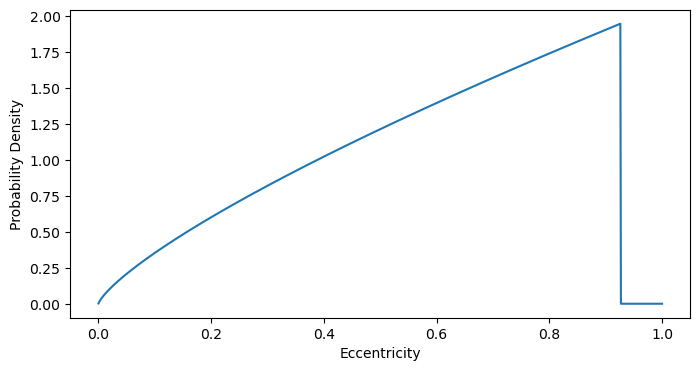

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
e = np.linspace(0, 1, 1000)
ax.plot(e, e_prob(e), label='Eccentricity Distribution')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Probability Density')

You can try to plot this distribution for different combinations of $m_1$ and $\log P$ (up to reproducing Figure 3 in the BOSSA paper), and see the variety of behaviors it creates: some orbits strongly favor eccentricity, while others strongly favor circularity, and some are almost uniformly distributed.

<div style="border:1px solid #f1c40f; background-color:#fcf8e3; padding:1em; border-radius:5px; max-width:80%; box-sizing:border-box; overflow-wrap:break-word; text-align: justify;">
    <strong>🟨 Question 1</strong><br>
    Why does the distribution drop to 0 at high eccentricities? Wy does this drop move with orbital period?
</div>

<br>

<div style="border:1px solid #f1c40f; background-color:#fcf8e3; padding:1em; border-radius:5px; max-width:80%; box-sizing:border-box; overflow-wrap:break-word; text-align: justify;">
    <strong>🟨 Question 2</strong><br>
    Which kinds of binaries favor more eccentric orbits, and which more circular orbits? Even without a detailed picture of stellar formation, do you have an intuition for those trends?
</div>

We can approach the mass ratio distribution in the same way. 

In [11]:
q_distr = MassRatioDistribution(canonical=False)
q_distr.set_parameters(30, 2)  # using m1=30 Msun and log P/d = 2 as a benchmark
q_prob = np.vectorize(q_distr.prob)

q_distr_canon = MassRatioDistribution(canonical=True)
q_distr_canon.set_parameters(30, 2)
q_prob_canon = np.vectorize(q_distr_canon.prob)

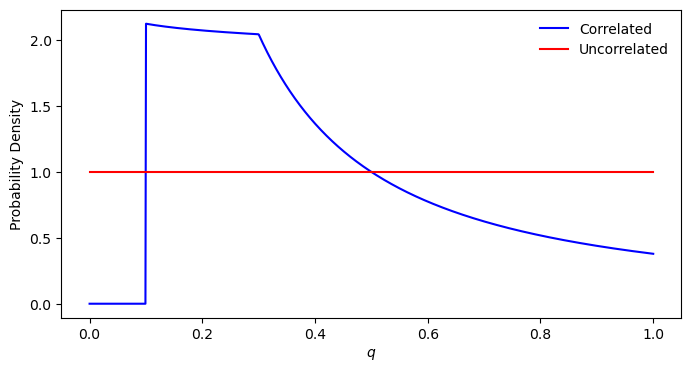

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

q = np.linspace(0, 1, 1000)
ax.plot(q, q_prob(q), label='Correlated', color='blue')
ax.plot(q, q_prob_canon(q), label='Uncorrelated', color='red')
ax.set_xlabel('$q$')
ax.set_ylabel('Probability Density')
ax.legend(frameon=False)

Here, the "canonical" (although this term is used in the code, it is problematic in writing) or Uncorrelated distribution is simply a uniform distribution (as usually attributed to Sana et al., 2012). As before, you can try plotting the Correlated distribution for different combinations of $m_1$ and $\log P$, up to reproducing Figure 2 in the BOSSA paper. You will also varying behavior, including the position of the distribution peak, the presence of a twin excess and cases in which it is close to uniform.

**Note:** the drop at $q=0.1$ is a limitation in the data from Moe & Di Stefano (2017). Remember that this will mean that, when drawing an initial population for COMPAS, this would mean you miss all binaries with initial $q<0.1$.

<div style="border:1px solid #f1c40f; background-color:#fcf8e3; padding:1em; border-radius:5px; max-width:80%; box-sizing:border-box; overflow-wrap:break-word; text-align: justify;">
    <strong>🟨 Question 3</strong><br>
    Which kinds of binaries favor more assymetric masses, and which favor more symmetric masses? Even without a detailed picture of stellar formation, do you have an intuition for those trends? 
</div>

### Companion frequency

Things start to get trickier physically with the companion frequency, which is effectively our orbital period distribution.

In [13]:
help(CompanionFrequencyDistribution)

Help on class CompanionFrequencyDistribution in module bossa.zams:

class CompanionFrequencyDistribution(CompanionFrequencyDistributionHighQ)
 |  CompanionFrequencyDistribution(m1: float, q_distr: float, uncorrelated: bool = False, extrapolate_uncorrelated_distribution: bool = False) -> None
 |
 |  Orbital period distribution for a ``0.1<=q<=1`` ZAMS star pair.
 |
 |  For a primary of mass ``m1``, compute the log orbital period
 |  (``logp``) probability density function (PDF) for a companion with
 |  some mass ``m_cp`` such that ``0.3 <= q <= 1.0`` (``q=m_cp/m1``).
 |
 |  Allows for either a strongly ``m1``- and ``logp``-dependent piecewise
 |  function of power-law, linear and exponential components; or a
 |  uniform on ``logp`` distribution.
 |
 |  All orbital periods are given in days and masses in solar masses.
 |
 |  Parameters
 |  ----------
 |  m1 : float
 |      Primary mass.
 |  q_distr : :class:`MassRatioDistribution`
 |      Mass ratio distribution for the same :attr:`m1`.


In [14]:
companion_freq = CompanionFrequencyDistribution(
    30,
    q_distr,
    uncorrelated=False
    )

The companion frequency distribution does not require setup. The companion frequency can be be found straight away by calling `companion_frequency_q01` with some $\log P$. However, note that it does require a `MassRatioDistribution` object to be passed, which will be used to extrapolate the companion frequency from $q>0.3$ down to $q>0.1$ (equation 15 in the BOSSA paper).

In [15]:
companion_freq.companion_frequency_q01(1)

0.32033634434461505

Setting `uncorrelated=False` will instead access our standard uncorrelated orbital period log-uniform distribution. Setting `extrapolate_uncorrelated_distribution=True` allows that distribution to be extrapolated to the same range of parameter as that for which the correlated companion frequency was defined in Moe & Di Stefano (2017).

In [16]:
companion_freq_uncorr = CompanionFrequencyDistribution(
    30,
    q_distr_canon,
    uncorrelated=True,
    extrapolate_uncorrelated_distribution=True
    )
companion_freq_uncorr.companion_frequency_q01(1)

0.12820512820512822

In [17]:
c_freq_uncorr = np.vectorize(companion_freq_uncorr.companion_frequency_q01)
c_freq = np.vectorize(companion_freq.companion_frequency_q01)

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1003257/2646439837.py:5: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\log P/\mathrm{d}$')
/tmp/ipykernel_1003257/2646439837.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$f_{\log P; q\geq0.1}(m_1)$')


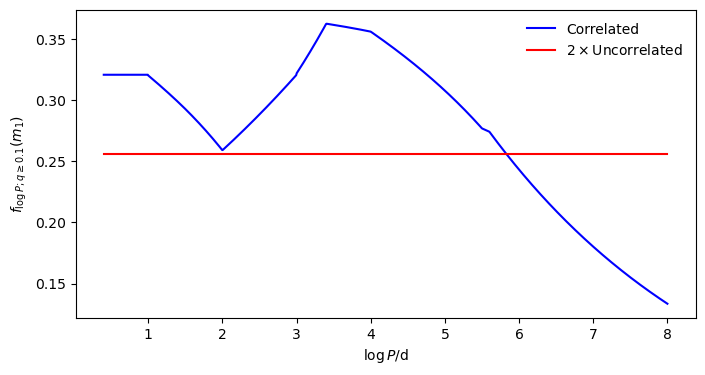

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
logp = np.linspace(0.4, 8, 1000)
ax.plot(logp, c_freq(logp), label='Correlated', color='blue')
ax.plot(logp, 2*c_freq_uncorr(logp), label='$2\\times$Uncorrelated', color='red')
ax.set_xlabel('$\log P/\mathrm{d}$')
ax.set_ylabel('$f_{\log P; q\geq0.1}(m_1)$')
ax.legend(frameon=False)

As before, you can try out the uncorrelated distributions for different values of $m_1$, and reproduce Figure 4.

<div style="border:1px solid #f1c40f; background-color:#fcf8e3; padding:1em; border-radius:5px; max-width:80%; box-sizing:border-box; overflow-wrap:break-word; text-align: justify;">
    <strong>🟨 Question 4</strong><br>
    As you vary <em>m</em><sub>1</sub>, you will notice that the position of the main peak around ~10<sup>4</sup> d varies, as does the height of the <10 d plateau. Do you understand the underlying star formation mechanisms that favors shorter or longer orbital periods for different masses?
</div>

hich kinds of binaries favor more assymetric masses, and which favor more symmetric masses? Even without a detailed picture of stellar formation, do you have an intuition for those trends? 

While the uncorrelated distribution can be interpreted as a probability density function for $P$, the companion frequency from Moe & Di Stefano (2017) accounts for multiple systems of arbitrary order. It is defined as 

$$
f_{\\log P}(m_1) = \frac{\mathrm{d} N_\mathrm{cp}} {\mathrm{d} N_1 \mathrm{d}\log P},
$$

and expresses the average number of companions per primary of mass $m_1$, per decade of orbital period. In order to find the orbital period distribution of physical binaries, one would need to separate the contribution of binaries from that of triples, quadruples... and so on. This is not a trivial process. One alternative is to simply treat all multiples as binaries, as a first approximation. This is often done, and allows the companion frequency to be interpreted as a probability distribution over $P$. 

In order to separate the contribution or binaries individually, or to even account for higher-order multiples, additional information is needed. In particular, we need to know how the *multiple fractions* behave as a function of mass (often *multiplicity statistics*).

<div style="border:1px solid #f1c40f; background-color:#fcf8e3; padding:1em; border-radius:5px; max-width:80%; box-sizing:border-box; overflow-wrap:break-word; text-align: justify;">
    <strong>🟨 Question 5</strong><br>
    From the companion frequency, can you compute the average number of companions per primary as a function of <em>m</em><sub>1</sub>? This quantity is known as the <em>multiplicity frequency</em>. From what masses do most stars have at least one companion? And two?  
    <details>
        <summary><em>Hint</em></summary>
        <code>MultipleFraction</code><em>, in the next section, computes the companion frequency, and uses it as described in section 2.2.4 of the BOSSA paper.</em>
    </details>
</div>

<br>

<div style="border:1px solid #f1c40f; background-color:#fcf8e3; padding:1em; border-radius:5px; max-width:80%; box-sizing:border-box; overflow-wrap:break-word; text-align: justify;">
    <strong>🟨 Question 6</strong><br>
    The <em>maximum star mass</em>, <em>M</em><sub>max</sub>, is an important quantity for population synthesis of massive stars for compact objects, especially for extreme scenarios that favor very massive stars, such as the occurence of very massive star (VMS) winds, direct collapse to a black hole, or chemically homogeneous evolution. Many different assumptions are found in the literature, from 100 to 300<em>M</em><sub>&#8857</sub>. Starting from Question 5, how does the assumed <em>M</em><sub>max</sub> affect multiplicity statistics? How many companions would you need to allow in your sample to account for all stars up to different <em>M</em><sub>max</sub>?
</div>


### Multiplicity statistics

The last class we work with for orbital parameters is `MultipleFraction`, which implements a Poissonian probability distribution for the companion number, $n_\mathrm{cp}$, as a function of $m_1$.

In [19]:
help(MultipleFraction)

Help on class MultipleFraction in module bossa.zams:

class MultipleFraction(builtins.object)
 |  MultipleFraction(mmin: float = 0.8, mmax: float = 150.0, nmax: int = 3, nmean_max: int = 11, only_binaries: bool = False)
 |
 |  Multiplicity fractions as a function of primary mass.
 |
 |  For a given primary mass ``m1``, compute the probability of having
 |  ``n`` companions in `` 0.1 <= q <= 1.0`` pairs. The probability
 |  distribution over ``n`` is discrete, and takes the form of a
 |  truncated Poisson distribution.
 |
 |  Can return individual multiplicity fractions for up to :attr:`nmax`
 |  companions, or compute a binary fraction by assuming all
 |  non-isolated stars are in binaries.
 |
 |  All masses are in solar masses.
 |
 |  Parameters
 |  ----------
 |  mmin : float
 |      Minimum primary mass.
 |  mmax : float
 |      Maximum primary mass.
 |  nmax : float
 |      Maximum companion number.
 |  nmean_max : float
 |      Maximum mean companion number, for interpolation.
 | 

We now again have a setup method. This is calculating the multiple fractions requires normalizing the $n_\mathrm{cp}$ distribution by the multiplicity frequency as a function of $m_1$, which is found by integrating numerically over the companion frequency (Sec. 2.2. 4). The integration is done only once, by `solve`, and used to define an interpolator.

In [22]:
m_frac = MultipleFraction(
    mmin=0.8,
    mmax=150.,
    nmax=4,
    nmean_max=11,
    only_binaries=False
)
m_frac.solve()

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 4.5776 s.


There a few useful methods to call from `MultipleFraction`. For a fixed $m_1$, we can get the mean number of companions. Note how this grows up to $10$ for $m_1=150\,\mathrm{M}_\odot$. This is a consequence of extrapolating the normalization of the original companion frequency distribution, and letting it increase indefinetly with mass. That is likely an extreme assumption, and could be changed in the source code.

Text(0, 0.5, 'Mean Number of Companions')

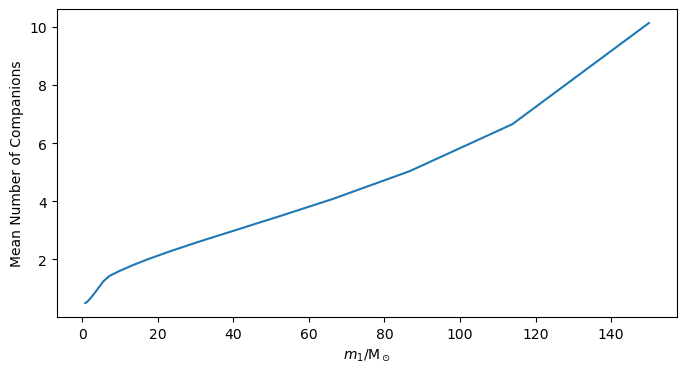

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
m1 = np.linspace(0.8, 150, 1000)
ax.plot(m1, m_frac.ncomp_mean(m1), label='Multiple Fraction')
ax.set_xlabel('$m_1/\\mathrm{M}_\\odot$')
ax.set_ylabel('Mean Number of Companions')

With the mean number of companions for a given mass, we can get the probability of a primary of that mass having different numbers of companions up to the maximum (the `nmax` parameter).

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1003257/1601994312.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$n_\mathrm{cp}$')
/tmp/ipykernel_1003257/1601994312.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathcal{F}_{n_\mathrm{cp}}(m_1)$')


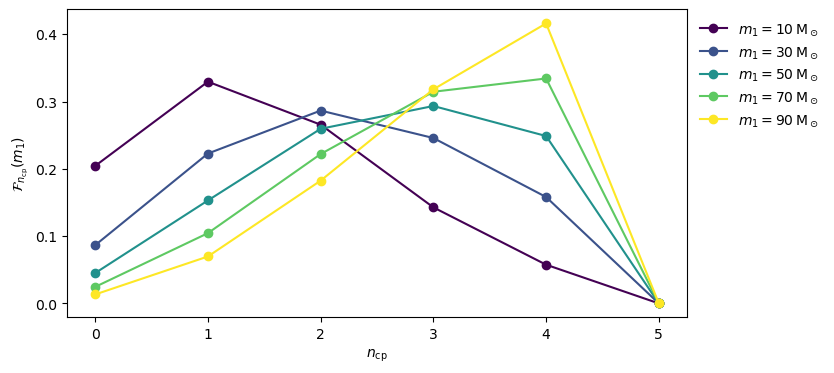

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ncp = np.arange(0, 6, 1)
m1_arr = np.arange(10, 110, 20)

for i, m1 in enumerate(m1_arr):
    c = cm.viridis(i / (len(m1_arr)-1))
    ncomp_mean = m_frac.ncomp_mean(m1)
    fracs = m_frac.prob(ncomp_mean, ncp)
    ax.plot(ncp, fracs, 'o-', c=c, label=f'$m_1={m1:.0f} \\, \\mathrm{{M}}_\\odot$')
ax.set_xlabel('$n_\mathrm{cp}$')
ax.set_ylabel('$\mathcal{F}_{n_\mathrm{cp}}(m_1)$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))


This is the "All Multiples" (AM) model defined in the BOSSA paper. This $\mathcal{F}_{n_\mathrm{cp}}(m_1)$ can be effectively treated as the probability of a primary of mass $m_1$ to have $n_\mathrm{cp}$ companions; it can then be used to draw $n_\mathrm{cp}$ for a given primary. BOSSA draws $n_\mathrm{cp}$ in that way, and then draws $n_\mathrm{cp}$ orbital periods from the companion frequency, ordering the companions from the shortest to the longest orbit. The closest is the *inner binnary*, which in some cases may be evolved without accounting for the effect of further companions. Otherwise, only physical binaries ($n_\mathrm{cp}=1$) can be evolved with codes like COMPAS.

All multiples can be assumed to be binaries in the Only Binaries (OB) model, yielding a single binary fraction. This is implemented for `only_binaries=True`.

In [65]:
m_frac = MultipleFraction(
    mmin=0.8,
    mmax=150.,
    nmax=4,
    nmean_max=11,
    only_binaries=True
)
m_frac.solve()

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 4.5969 s.


If we then try to reproduce our last plot, we simply get the evolution of the binary fraction with mass (and an incovenient visualization). Note that massive stars are nearly all in binaries.

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1003257/1601994312.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$n_\mathrm{cp}$')
/tmp/ipykernel_1003257/1601994312.py:11: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mathcal{F}_{n_\mathrm{cp}}(m_1)$')


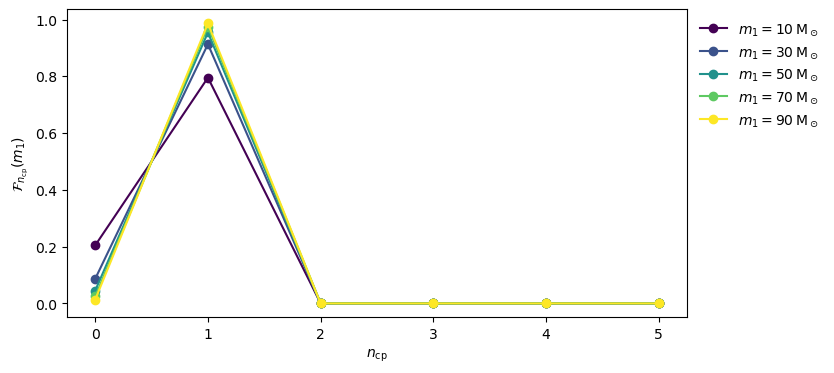

In [66]:
fig, ax = plt.subplots(figsize=(8, 4))
ncp = np.arange(0, 6, 1)
m1_arr = np.arange(10, 110, 20)

for i, m1 in enumerate(m1_arr):
    c = cm.viridis(i / (len(m1_arr)-1))
    ncomp_mean = m_frac.ncomp_mean(m1)
    fracs = m_frac.prob(ncomp_mean, ncp)
    ax.plot(ncp, fracs, 'o-', c=c, label=f'$m_1={m1:.0f} \\, \\mathrm{{M}}_\\odot$')
ax.set_xlabel('$n_\mathrm{cp}$')
ax.set_ylabel('$\mathcal{F}_{n_\mathrm{cp}}(m_1)$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))


How do the multiple fractions in the AM model, and the binary fraction in the OB model, vary with the assumed $n_{\max}$? You can try plotting the above two plots for different values of that parameter. The results you will get underly Figures 5 and 6 in the BOSSA paper, respectively. Can you reproduce them?

<div style="border:1px solid #f1c40f; background-color:#fcf8e3; padding:1em; border-radius:5px; max-width:80%; box-sizing:border-box; overflow-wrap:break-word; text-align: justify;">
    <strong>🟨 Question 7</strong><br>
    BOSSA uses a default <code>nmax=4</code>. By looking at how the multiple fractions vary with `nmax`, do you understand why? Do you agree with this choice? 
</div>

The process of generating a sample of binaries that follow all distributions here and in the first notebook is implemented by `zams.ZAMSSystemGenerator`. That class, however, expects to generate an entire population from a pre-sampled list of masses. What we would like to do, instead, is to compute the weight (probability) of a single binary under different combinations of our correlated and uncorrelated models.

From the distributions we have seen so far, a single system, composed of a primary and some number $n_\mathrm{cp}$ companions, is defined by $2+3n_\mathrm{cp}$ parameters: $m_1$, $n_\mathrm{cp}$, and one $(P, q, e)$ set for each companion. Therefore, the probability of a particular system being formed is

$$
\mathcal{P}(\mathrm{system})\propto\mathcal{P}(m_1)\times
\mathcal{P}(n_\mathrm{cp})\times
\prod_{i=1}^{n_\mathrm{cp}}\left(
    \mathcal{P}(P_i)\times
    \mathcal{P}(q_i)\times
    \mathcal{P}(e_i)
\right).
$$

Your final goal, after reading through the notebook and working through some of its questions, should be to able to compute $\mathcal{P}(\mathrm{system})$ under different combinations of assumed initial distributions. 

<div style="border:1px solid #f1c40f; background-color:#fcf8e3; padding:1em; border-radius:5px; max-width:80%; box-sizing:border-box; overflow-wrap:break-word; text-align: justify;">
    <strong>🟨 Question 8</strong><br>
    Chemically homogeneous evolution (CHE) is a hypothetic extreme channel for binary black hole formation, wherein two massive stars in very close orbits are spun-up by tides to such a degree that rotation induces efficient internal mixing. This keeps the stars chemically homogeneous, so that by the end of the Main Sequence they are fully helium-rich, do not expand into supergiants and do not suffer Roche lobe overflow, which would be accompanied by loss of mass from the system. This makes them interesting candidates for producing particularly massive pairs of merging black holes. <br><br>
    A typical candidate for producing massive merging black holes from CHE has <em>m</em><sub>1</sub>=90 M<sub>&#8857</sub>, <em>n</em><sub>cp</sub>=1, <em>P</em><sub>1</sub>=1.5 d, <em>q</em><sub>1</sub>=1 and <em>e</em><sub>1</sub>=0. Bringing also your knowledge of the IMF classes, what is the weight of this system for two different sets of initial distributions of your choice?
</div>